# Force chains in emulsion gels


## About this notebook
In this notebook we perform the analysis of the experimental data. The data are stored in the `data` folder

In [116]:
ls data

libc++abi.dylib: terminating with uncaught exception of type std::runtime_error: Couldn't close file


Each folder contains pure `txt` files with the original data from Jun and `xyz` files that can be rendered in `Ovito` or `VMD`.

In [117]:
ls data/phi_p_1.2/

libc++abi.dylib: terminating with uncaught exception of type std::runtime_error: Couldn't close file


Lengthy and complex algorithms should be stored in the folder `src`

In [118]:
ls src

libc++abi.dylib: terminating with uncaught exception of type std::runtime_error: Couldn't close file


## Visualising the data

We first import the basic numerical and visuaisation modules. If they are missing, thhey can be install via `pip install module-name`. For example 

`pip install ipyvolume`

In [119]:
import numpy as np
import scipy as sp
import ipyvolume as ipv
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [120]:
%load_ext autoreload
%autoreload 2
from src import io

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [121]:
pol = 2.0
centres = io.Centres(f"data/phi_p_{pol}/coords.xyz")
contacts = io.Contacts(f"data/phi_p_{pol}/contacts.xyz")

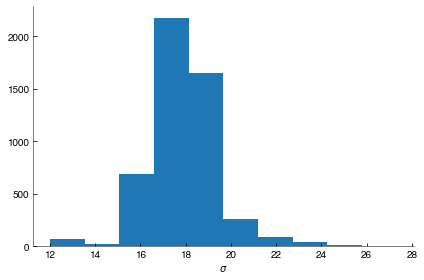

In [122]:
plt.hist(2*centres.radius); plt.xlabel('$\sigma$');

In [123]:
x, y, z = centres.unpack()
color = np.array([(x-x.min())/x.ptp(),np.ones_like(x), np.ones_like(x)]).T
ipv.scatter(x, y, z, size=centres.radius/2.5, marker="sphere", color=color)

x, y, z = contacts.unpack()
ipv.scatter(x, y, z, size=0.9, marker="sphere", color='red')
ipv.show()

## Example of analysis

We show hee how we can proceed to explore the data. For example, we get the nearest contacts for every particle centre. To do so, we fix a cutoff radius `rcut` for our search. 

In [124]:
from scipy.spatial import cKDTree

rcut = centres.radius.mean()*1.2
centre_tree = cKDTree(centres.coord)
contact_tree = cKDTree(contacts.coord)
centre_contacts=centre_tree.query_ball_tree(contact_tree, rcut)

By the same means, we can easily estimate the radial distribution function `g(r)`.

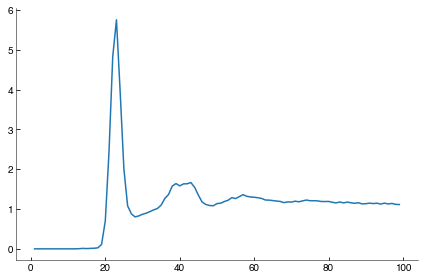

In [125]:
centres.get_gr()
plt.plot(centres.gr['r'],centres.gr['g']);

Similarly, we can compute the coordination within a larger cutoff, for example around the first minimum of `g(r)`.

In [126]:
rcut = 27
neighs=centre_tree.query_ball_tree(centre_tree,rcut)
coordination = [len(n)-1 for n in neighs]

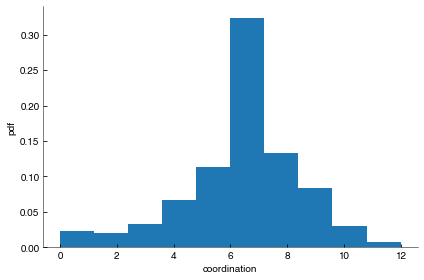

In [127]:
plt.hist(coordination, density=True); plt.xlabel('coordination');plt.ylabel('pdf');

In [128]:
centre_contacts_weights = []
num_contacts = []
for c in centre_contacts:
    w = []
    if len(c)>0:
        w=list(contacts.volume[c])
    
    num_contacts.append(len(c))
    centre_contacts_weights.append(w)

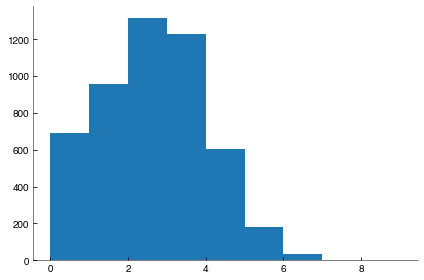

In [129]:
plt.hist(num_contacts,bins=np.arange(10));

# Stress Tensor

The stress data from Jun are stored in a different sub-folder

In [130]:
ls data/stressTensor/

libc++abi.dylib: terminating with uncaught exception of type std::runtime_error: Couldn't close file


In [131]:
ls data/stressTensor/'{pol}'

libc++abi.dylib: terminating with uncaught exception of type std::runtime_error: Couldn't close file


The stress data are easily read into the `centres` object

In [132]:
centres.get_stress_info(f'data/stressTensor/{pol}/', rcut=28)

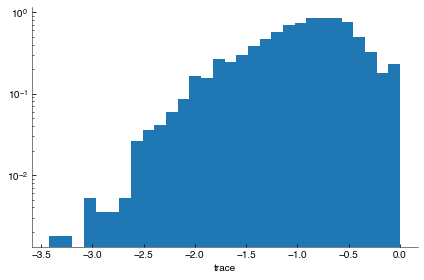

In [133]:
plt.hist(centres.trace,bins=30, density=True);
plt.yscale('log')
plt.xlabel('trace');

The  minor stress is the most negative one as we are following the tension-positive convention of Peteres _et al_ PRE 2005

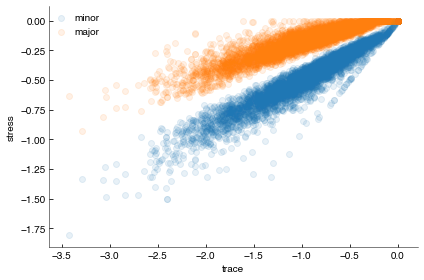

In [134]:
plt.scatter(centres.trace,centres.minor, alpha=0.1, label='minor')
plt.scatter(centres.trace,centres.major, alpha=0.1, label = 'major')
plt.xlabel('trace')
plt.ylabel('stress');
plt.legend();

Compute a weighted g(r) 

In [135]:
centres.get_gr(rmax=100,dr=1.)
# select a threshold
def compare_g(threshold):
    mgr = centres.get_masked_gr(centres.trace, threshold)
    plt.plot(centres.gr['r'],centres.gr['g'])
    plt.plot(mgr['r'],mgr['g'])
    
interact(compare_g,threshold=widgets.FloatSlider(min=-3, max=0, value=-1,continuous_update=False))

interactive(children=(FloatSlider(value=-1.0, continuous_update=False, description='threshold', max=0.0, min=-…

<function __main__.compare_g(threshold)>

In [136]:
interact(centres.plot_clusters,threshold=widgets.FloatSlider(min=-3, max=0, value=-1,continuous_update=False), rcut=fixed(28),size=fixed(5.0));


interactive(children=(FloatSlider(value=-1.0, continuous_update=False, description='threshold', max=0.0, min=-…

In [137]:
centres.pearsonr_coordination_z_slice(200,centres.local_aniso, plot=False)

0.2780419270877309

In [138]:
zs = np.arange(100,380,10)
profiles = centres.all_pearson_profiles(zs)
print (profiles.keys())

dict_keys(['z', 'trace_profile', 'aniso_profile', 'major_profile', 'minor_profile'])


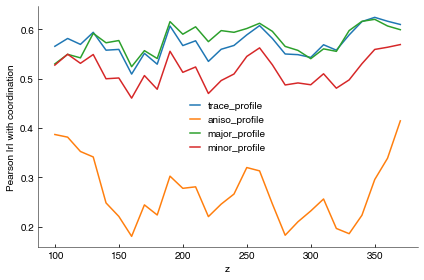

In [139]:
for k,v in profiles.items():
    if 'profile' in k:
        plt.plot(zs,np.absolute(v),label=k)
plt.legend()
plt.xlabel('z'),plt.ylabel('Pearson |r| with coordination');
plt.savefig('figs/profile_ correlations.png')

/Users/francesco/Repos/canard-enchaine/src/io.py:156: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  q2_name = [ k for k,v in locals().items() if np.all(v == quantity2)][0]


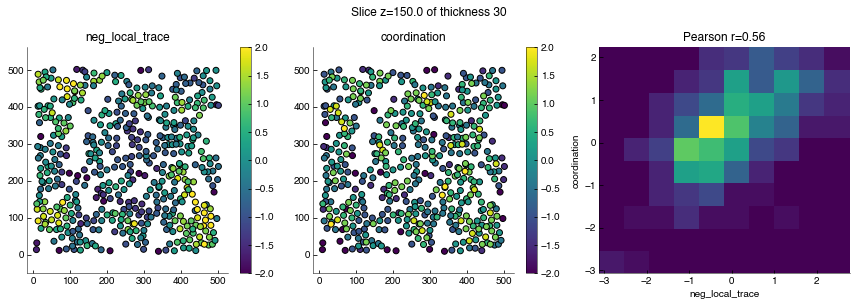

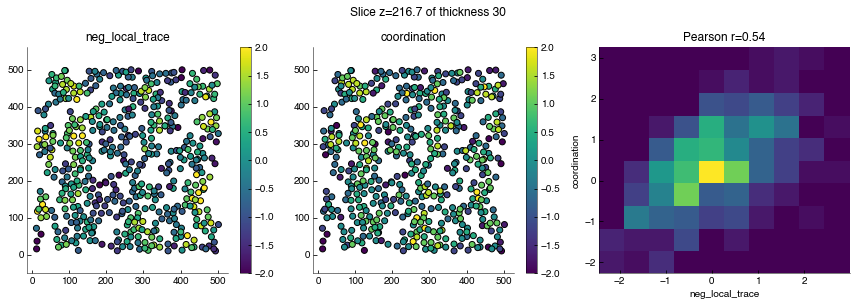

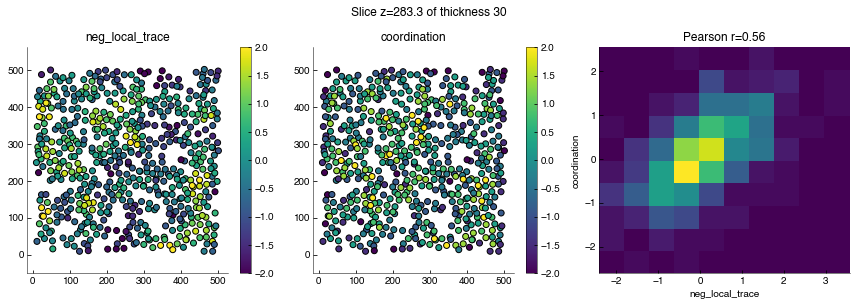

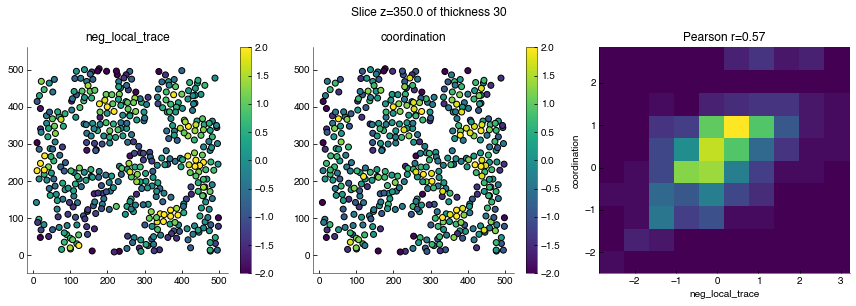

In [140]:
for z in np.linspace(150,350,4):
    centres.plot_sample_slices(z,-centres.local_trace,centres.stress_coordination, feature_scaling=True, thickness=30,border=10)
    plt.savefig(f'figs/correlations/p{pol}/traceVScoord-z{z}.pdf')


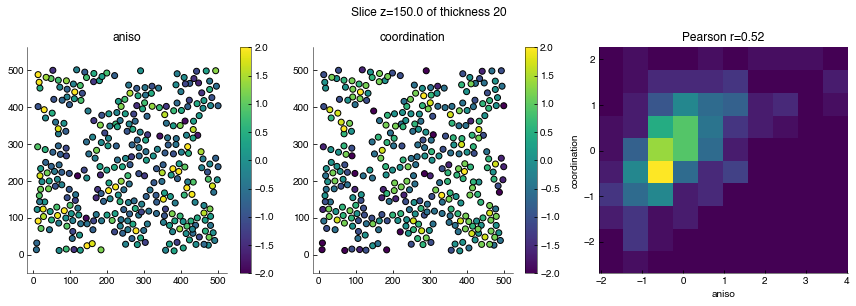

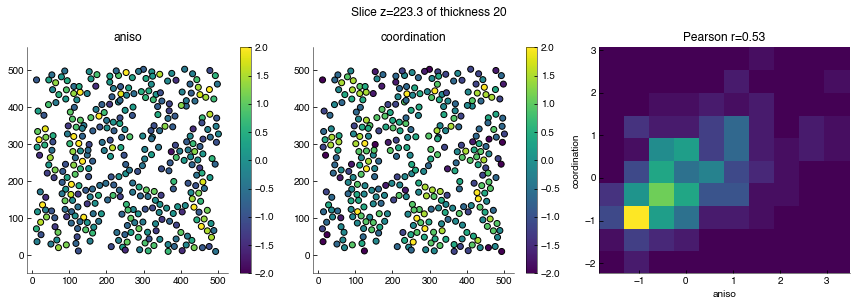

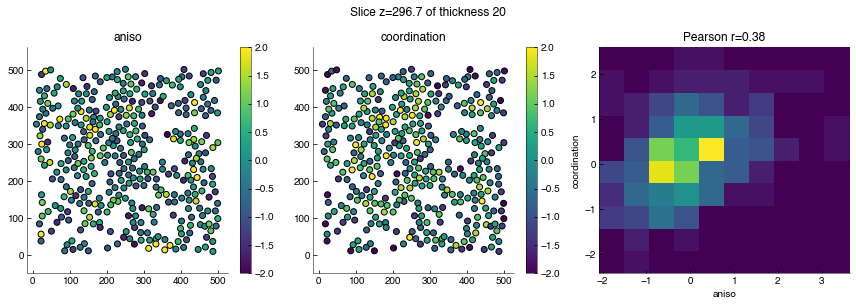

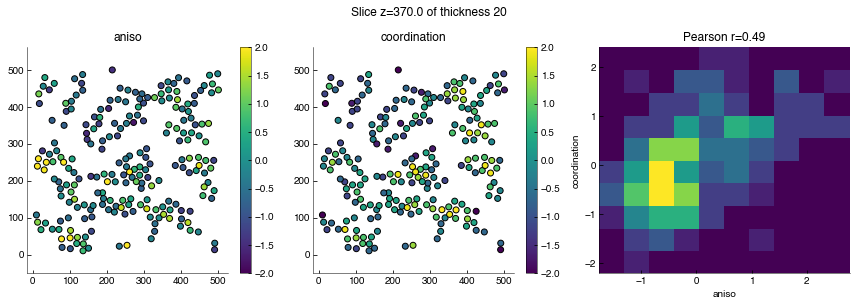

In [141]:
for z in np.linspace(150,370,4):
    centres.plot_sample_slices(z,centres.aniso,centres.stress_coordination, feature_scaling=True, thickness=20,border=20)
    plt.savefig(f'figs/correlations/p{pol}/anisoVScoord-z{z}.pdf')

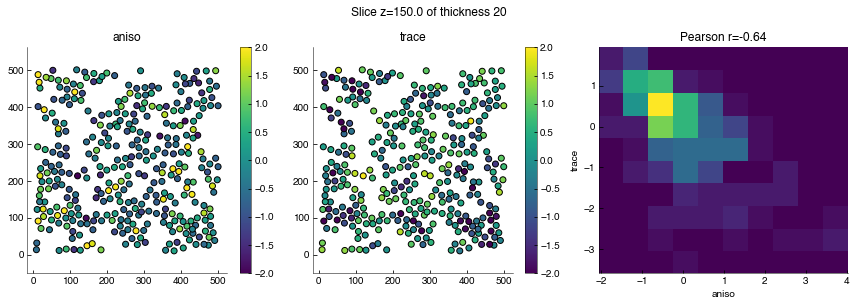

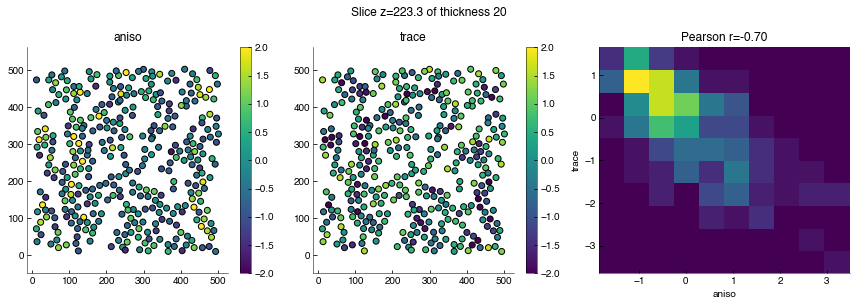

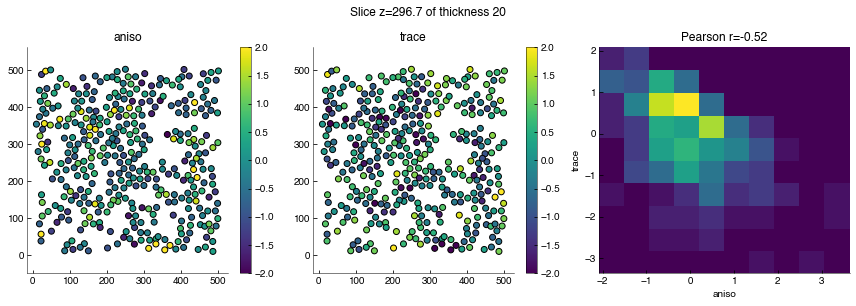

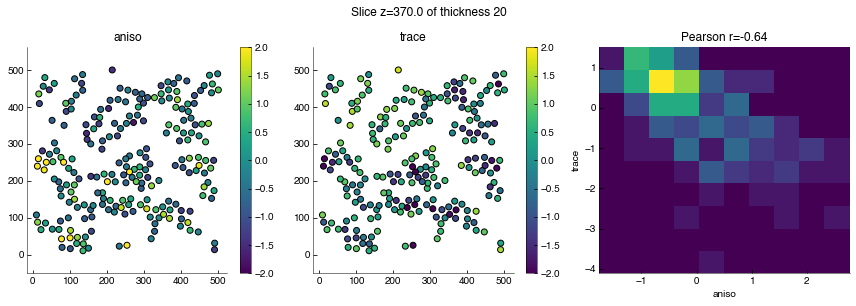

In [142]:
for z in np.linspace(150,370,4):
    centres.plot_sample_slices(z,centres.aniso,centres.trace, feature_scaling=True, thickness=20,border=20)
    plt.savefig(f'figs/correlations/p{pol}/anisoVtrace-z{z}.pdf')

## Network construction

We need to find common contacts to construct edges.

In [143]:
import networkx as nx
from src import network

peak 3.0
mean 74.74008842501993
std 46.50453770377187


135.0

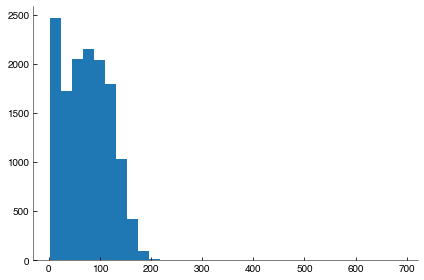

In [144]:
plt.hist(contacts.volume,bins=32);
H, e = np.histogram(contacts.volume,bins=32)
print('peak',e[:-1][H.argmax()])
print('mean', np.mean(contacts.volume))
print('std', np.std(contacts.volume))
np.percentile(contacts.volume,90)

In [145]:
G = network.ContactNetwork(centres,contacts,percentile=95)

 The number of contacts with no neighbouring particles is 9


In [146]:
G.export_components()

From the Graph we can extract many possible metrics. For example the **deegre assortativity** measures to what extent nodes with similar degrees cluster together (see Newman PRE 67, 026126 􏰒2003􏰀).

In [147]:
nx.degree_assortativity_coefficient(G.graph)

0.18117629000486016

Simple geometrical measures are also possible, such as the **number of triangles**.

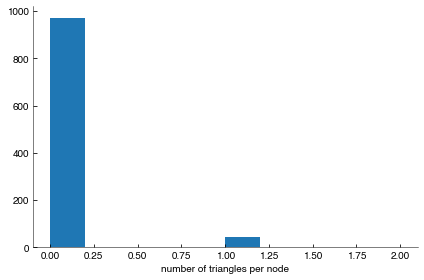

In [148]:
plt.hist(nx.triangles(G.graph).values());
plt.xlabel("number of triangles per node");

We can for example compute the **transitivity** $T$ as
$$T=3 \frac{\# \text { triangles }}{\# \text { triads }}$$
which is $T=1$ for complete graphs (where every pair of nodes is connected by a single edge).

In [149]:
nx.transitivity(G.graph)

0.11409395973154363

![figs/transitivity.png](figs/transitivity.png)